# Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

import warnings
warnings.filterwarnings("ignore")

# Load Dataset

In [3]:
df=pd.read_csv('../input/nifty50-stock-market-data/ICICIBANK.csv')
df=df[['Date','Open']]
print(df.shape)
df.head()

(5163, 2)


,Date,Open
0,2000-01-03,74.35
1,2000-01-04,73.05
2,2000-01-05,70.00
3,2000-01-06,71.00
4,2000-01-07,69.00


# Make Date column as Index and dtype datetime 

In [4]:
df.index=pd.to_datetime(df['Date'])
df.drop('Date',axis=1,inplace=True)
#df=df[(df.index>='2015') & (df.index<'2020')]
df.head()

,Open
Date,
2000-01-03,74.35
2000-01-04,73.05
2000-01-05,70.00
2000-01-06,71.00
2000-01-07,69.00


# Plotting

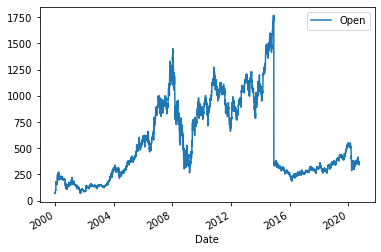

In [5]:
df.plot()

In [6]:
df['Open'].autocorr()

0.9974540063789649

From the Autocorrelation, we can say that todays prices is highly corelated with yesterday's price

# Take only Past 6yr of Data

In [7]:
df=df[(df.index>='2015') & (df.index<'2020')]
print(df.shape)
df.head()

(1234, 1)


,Open
Date,
2015-01-01,352.7
2015-01-02,352.0
2015-01-05,365.3
2015-01-06,359.4
2015-01-07,345.6


0.9955627633728726


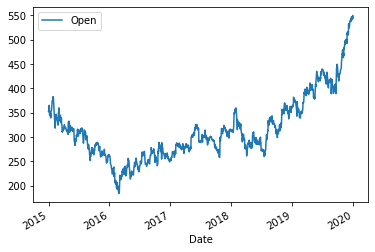

In [8]:
print(df['Open'].autocorr())
df.plot()

From the Autocorrelation, we can say that todays prices is highly corelated with yesterday's price

# AutoCorrelation of Past 5yr:

In [9]:
print(df[(df.index>='2015') & (df.index<'2015-12-31')]['Open'].autocorr())
print(df[(df.index>='2016') & (df.index<'2016-12-31')]['Open'].autocorr())

print(df[(df.index>='2017') & (df.index<'2017-12-31')]['Open'].autocorr())
print(df[(df.index>='2018') & (df.index<'2018-12-31')]['Open'].autocorr())
print(df[(df.index>='2019') & (df.index<'2019-12-31')]['Open'].autocorr())

0.9802250202638142
0.960836645084141
0.9586224461206558
0.9753657208535687
0.9896584236702162


# Analysing Data
1. Test for Random Walk (We can't forcast random walk )
2. If random walk make it stationary
3. Compute ACF and PACF (To determine order of AR or MA model)
4. Fit a few AR,MA and ARMA models
5. Use Information Criterion to select best model: \
AIC score will used to determine model becuase  AIC metrix tells us how good a model is. A  model which makes better predictions is given lower AIC score. 
6. Forecast Dec,2019 data using past 5yr of data 
7. Use automation to determine orders then fit and forecast

## 1. Test the time series is stationary or not:
Test it using Dickey-Fuller test 

In [152]:
#H0: Null Hypothysis (It is not stationary)
#H1: Alternate Hypothysis (It is stationary)

def test_rw(df):
    result=adfuller(df)
    labels=['ADF Test Statistic','p-Value','Lag Used','No. of Observations']
    for val,label in zip(result,labels):
        print(label,end="=")
        print (val) 

    if(result[1]<=0.05):
        print("Reject the Null Hypothesis (H0) and it is stationary")
    else:
        print("We can't Reject the Null Hypothesis (H0) and it is not a stationary")
    print("AutoCorrelation=",df.autocorr())
test_rw(df['Open'])        

ADF Test Statistic=0.12475882921764121
p-Value=0.967711402298576
Lag Used=0
No. of Observations=1233
We can't Reject the Null Hypothesis (H0) and it is not a stationary
AutoCorrelation= 0.9955627633728726


## 2. Make the stationary

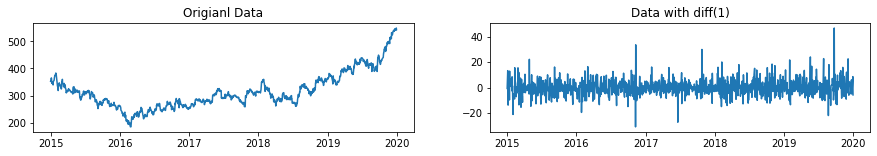

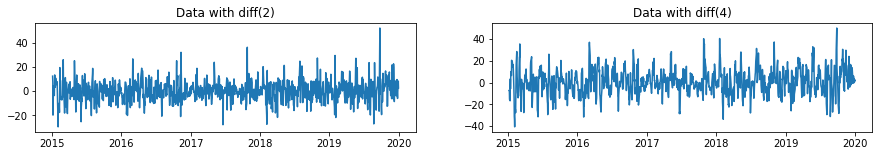

In [153]:
fig, (ax1, ax2) = plt.subplots(ncols=2,figsize=(15,2))
ax1.plot(df['Open'])
ax1.set_title("Origianl Data")

ax2.plot(df['Open'].diff(1))
ax2.set_title("Data with diff(1)")

fig, (ax1, ax2) = plt.subplots(ncols=2,figsize=(15,2))

ax1.plot(df['Open'].diff(2))
ax1.set_title("Data with diff(2)")

ax2.plot(df['Open'].diff(4))
ax2.set_title("Data with diff(4)")


plt.show()

In [154]:
test_rw(df['Open'].diff(1).dropna())

ADF Test Statistic=-36.44995955896344
p-Value=0.0
Lag Used=0
No. of Observations=1232
Reject the Null Hypothesis (H0) and it is stationary
AutoCorrelation= -0.03888853034562188


In [155]:
# hence after 1st difference time series become stationary
for i in [1,2,10,30,40,50,70,80,100,105,110,115,120,122,125,130,135,138,140]:
    temp=df['Open'].diff(i).dropna()
    result=adfuller(temp)
    if(result[1]<=0.05):
        print("At diff({}) it is stationary = {}".format(i,temp.autocorr()))    


At diff(1) it is stationary = -0.03888853034562188
At diff(2) it is stationary = 0.46795641455843134
At diff(10) it is stationary = 0.8836090456979017
At diff(30) it is stationary = 0.9536149421842213
At diff(40) it is stationary = 0.9613125958965462
At diff(50) it is stationary = 0.9647652081613296
At diff(70) it is stationary = 0.975139785592402
At diff(110) it is stationary = 0.9820584572569887
At diff(122) it is stationary = 0.9831063807060166


In [156]:
df2=pd.DataFrame()
df2['Open']=df['Open'].diff(122).dropna()
df2.index = pd.to_datetime(df2.index, format='%Y')
df2['Date']=df2.index
df2.index=pd.to_datetime(df2['Date'])
df2.drop('Date',axis=1,inplace=True)

df2.head()

,Open
Date,
2015-06-30,-42.65
2015-07-01,-43.30
2015-07-02,-51.00
2015-07-03,-47.65
2015-07-06,-36.50


## 3. Plot ACF and PACF to determine order of AR and MA
ACF is used to identify order of MA term, and PACF for AR. There is a thumb rule that for MA, the lag where ACF shuts off suddenly is the order of MA and similarly the lag where PACF shuts off suddenly is the order of AR

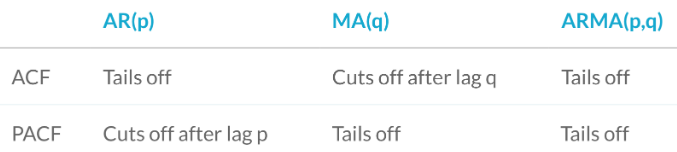

### 3.1 Identifying the order of AR model:

Figure(432x288)


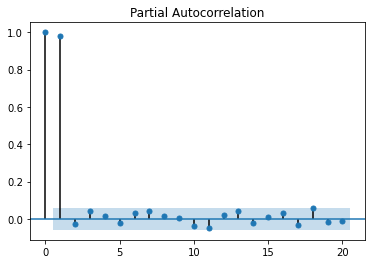

In [157]:
from statsmodels.graphics.tsaplots import plot_pacf
print(plot_pacf(df2, lags= 20, alpha=0.05))

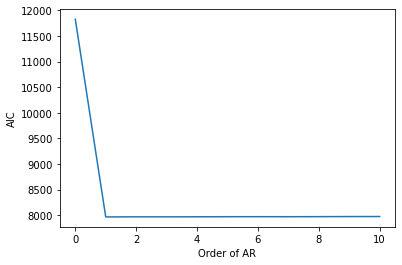

In [161]:
#lowest BIC hav

aic_values=[]
for i in range(0,11):
    #mod = ARMA(df2['Open'].values, order=(i,0))
    #result = mod.fit()
    model = SARIMAX(df2, order=(i,0,0))
    result = model.fit()
    aic_values.append(result.aic)
    
plt.plot(aic_values)
plt.xlabel("Order of AR")
plt.ylabel("AIC")
plt.show()

* From PACF plot and above graph, order of AR model will be 1 i.e AR(1)

### 3.2 Identifying the order of MA model:

Figure(432x288)


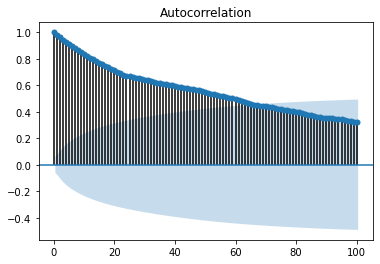

In [162]:
from statsmodels.graphics.tsaplots import plot_acf
print(plot_acf(df2['Open'], lags= 100, alpha=0.05))

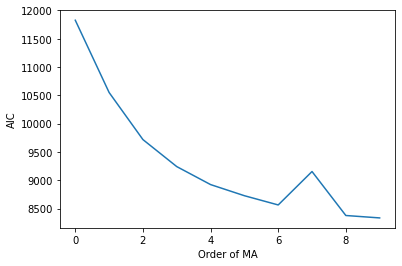

In [163]:
aic_values=[]
for i in range(0,10):
    try:
        #mod = ARMA(df2['Open'].values, order=(0,i))
        #result = mod.fit()
        
        model = SARIMAX(df2, order=(0,0,i))
        result = model.fit()
        aic_values.append(result.aic)
    except:
        pass

    
plt.plot(aic_values)
plt.xlabel("Order of MA")
plt.ylabel("AIC")
plt.show()

### 3.3 Identifying the order of ARMA model:

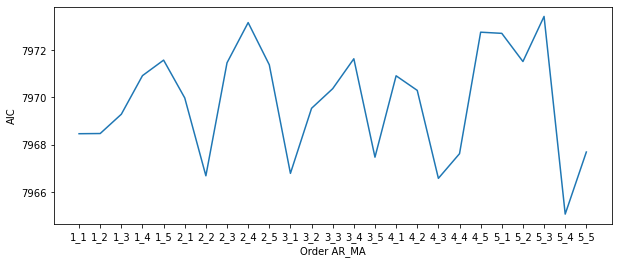

In [165]:
aic_values={}
for p in range(1,6):
    for q in range(1,6):
        try:
            #mod = ARMA(df2['Open'].values, order=(p,q))
            #result = mod.fit()
            model = SARIMAX(df2, order=(p,0,q))
            result = model.fit()
    
            aic_values[str(p)+'_'+str(q)]=result.aic
        except:
            pass
        
plt.figure(figsize=(10,4))
plt.plot(list(aic_values.values()))
plt.xticks(list(range(len(aic_values.keys()))),list(aic_values.keys()))
plt.xlabel("Order AR_MA")
plt.ylabel("AIC")
plt.show()        

ARMA(5,4) has lowest AIC score

In [167]:
print(aic_values['5_4'])

7965.071395693082


# Models
1. AR(1)
2. MA(10)
3. ARMA(5,4)

In [183]:
rmse={}

In [184]:
df_train=df2.iloc[df2.index<='2019-12-01']
df_test=df2[(df2.index>='2019-12-01')]

In [185]:
print(df_test.shape)
df_test.head()

(21, 1)


,Open
Date,
2019-12-02,86.45
2019-12-03,83.75
2019-12-04,92.30
2019-12-05,115.15
2019-12-06,116.55


In [186]:
print(df_train.shape)
df_train.head()

(1091, 1)


,Open
Date,
2015-06-30,-42.65
2015-07-01,-43.30
2015-07-02,-51.00
2015-07-03,-47.65
2015-07-06,-36.50


## 1. AR Model (AR(1))

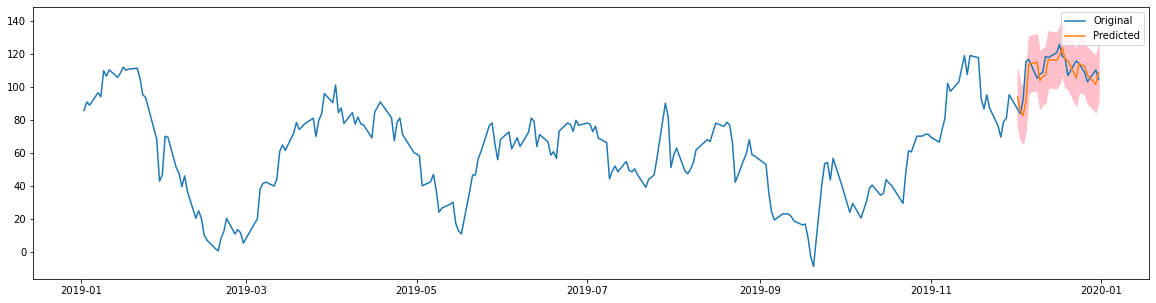

In [187]:
model=SARIMAX(df2, order=(1,0,0)) #order(p,d,q) p=1 i.e AR(1)
results = model.fit()

#2019-12-02 to 2019-12-31
forecast = results.get_prediction(start=-21)
y_pred=forecast.predicted_mean

# Get confidence intervals of forecasts
confidence_intervals = forecast.conf_int()

fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(df2[df2.index>'2019'])
ax.plot(y_pred)
# Shade uncertainty area
plt.fill_between(confidence_intervals.index, confidence_intervals['lower Open'], confidence_intervals['upper Open'], color='pink')

ax.legend(['Original','Predicted'])
plt.show()

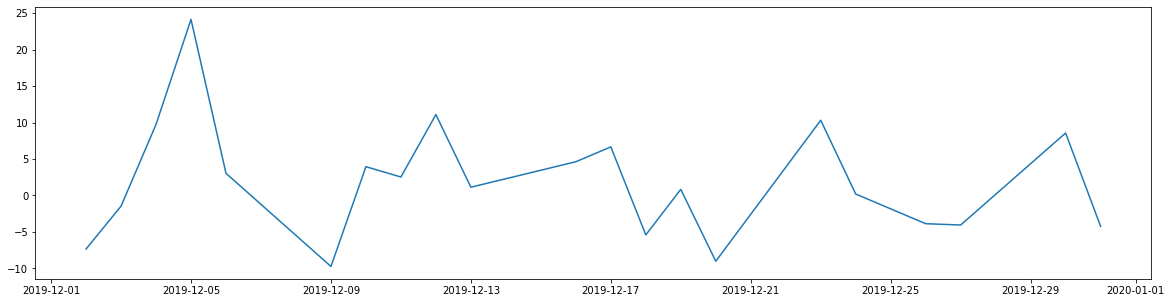

In [188]:
residuals=df_test['Open']-y_pred
#residuals
#np.sqrt(np.mean(residuals**2))
fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(residuals)
plt.show()

In [189]:
y_true=df_test.values
print("MSE = ",mean_squared_error(y_true, y_pred))
print("RMSE = ",np.sqrt(mean_squared_error(y_true, y_pred)))
rmse['AR_1']=np.sqrt(mean_squared_error(y_true, y_pred))

MSE =  66.28722851173464
RMSE =  8.141696906157502


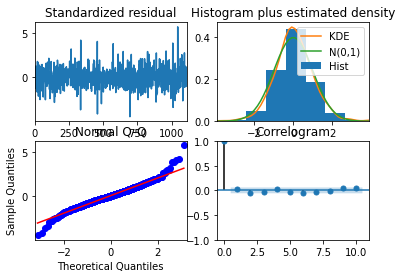

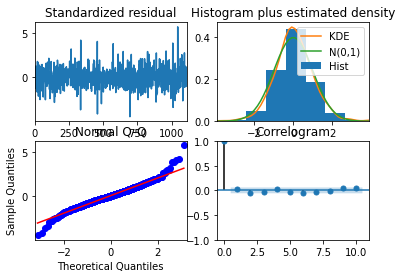

In [190]:
results.plot_diagnostics()

## 2. MA Model (MA(10))

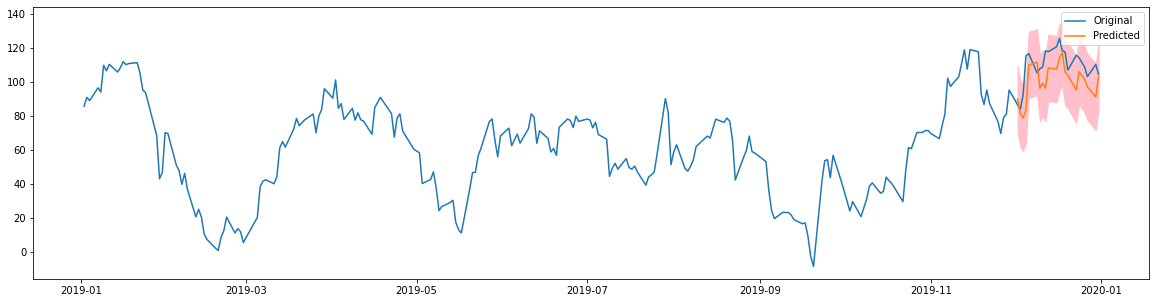

In [191]:
model=SARIMAX(df2, order=(0,0,10)) #order(p,d,q) q=10 i.e MA(10)
results = model.fit()

#2019-12-02 to 2019-12-31
forecast = results.get_prediction(start=-21)
y_pred=forecast.predicted_mean

# Get confidence intervals of forecasts
confidence_intervals = forecast.conf_int()

fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(df2[df2.index>'2019'])
ax.plot(y_pred)
# Shade uncertainty area
plt.fill_between(confidence_intervals.index, confidence_intervals['lower Open'], confidence_intervals['upper Open'], color='pink')

ax.legend(['Original','Predicted'])
plt.show()

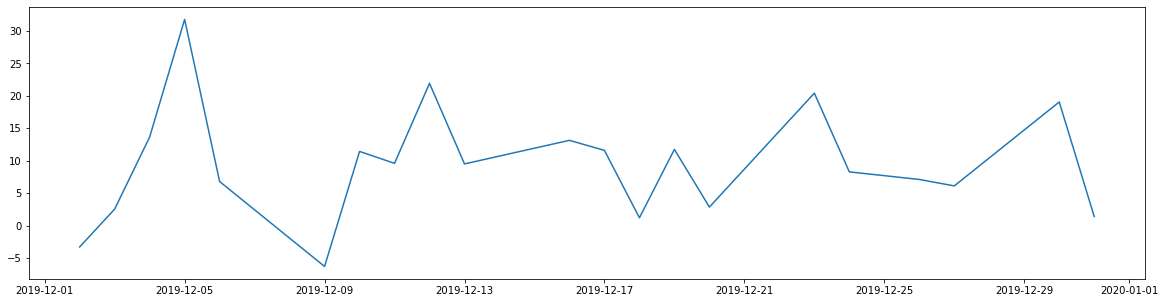

In [192]:
residuals=df_test['Open']-y_pred
#residuals
#np.sqrt(np.mean(residuals**2))
fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(residuals)
plt.show()

In [193]:
y_true=df_test.values

print("MSE = ",mean_squared_error(y_true, y_pred))
print("RMSE = ",np.sqrt(mean_squared_error(y_true, y_pred)))
rmse['MA_10']=np.sqrt(mean_squared_error(y_true, y_pred))

MSE =  165.81476257848757
RMSE =  12.876908114081097


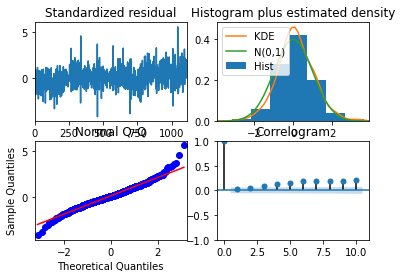

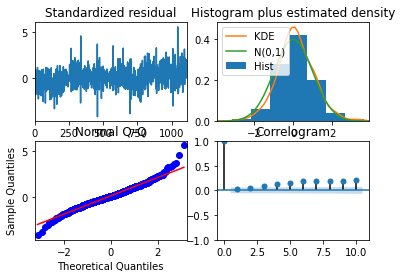

In [194]:
results.plot_diagnostics()

## 3. ARMA Model (ARMA(5,4))

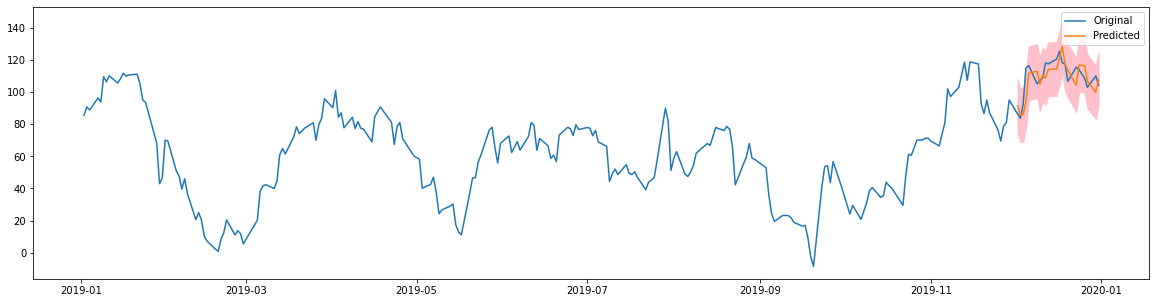

In [198]:
model=SARIMAX(df2, order=(5,0,4)) #order(p,d,q) p=5,q=4 i.e ARMA(5,4)
results = model.fit()

#2019-12-02 to 2019-12-31
forecast = results.get_prediction(start=-21)
y_pred=forecast.predicted_mean

# Get confidence intervals of forecasts
confidence_intervals = forecast.conf_int()

fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(df2[df2.index>'2019'])
ax.plot(y_pred)
# Shade uncertainty area
plt.fill_between(confidence_intervals.index, confidence_intervals['lower Open'], confidence_intervals['upper Open'], color='pink')

ax.legend(['Original','Predicted'])
plt.show()

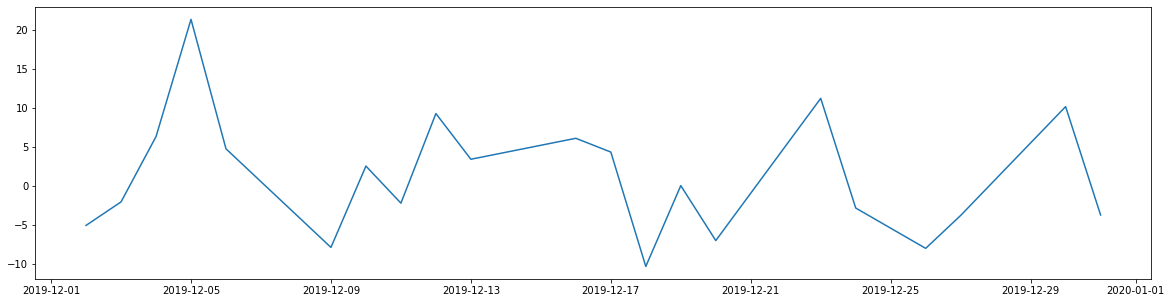

In [199]:
residuals=df_test['Open']-y_pred
#residuals
#np.sqrt(np.mean(residuals**2))
fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(residuals)
plt.show()

In [200]:
y_true=df_test.values

print("MSE = ",mean_squared_error(y_true, y_pred))
print("RMSE = ",np.sqrt(mean_squared_error(y_true, y_pred)))
rmse['ARMA_5_4']=np.sqrt(mean_squared_error(y_true, y_pred))

MSE =  59.95927618465782
RMSE =  7.743337535240074


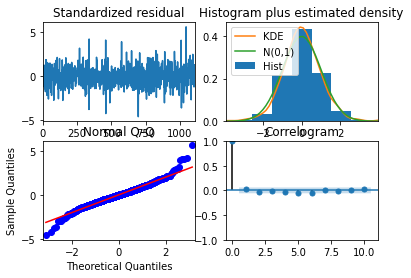

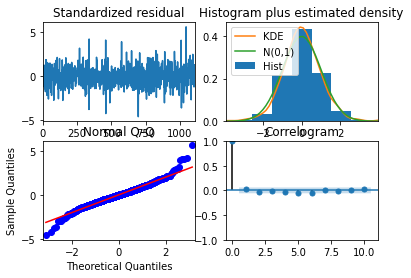

In [201]:
results.plot_diagnostics()

# Automation:Searching over model orders

In [112]:
pip install pmdarima

     |████████████████████████████████| 1.5 MB 192 kB/s eta 0:00:01
     |████████████████████████████████| 2.1 MB 5.5 MB/s eta 0:00:01
  Attempting uninstall: Cython
    Found existing installation: Cython 0.29.21
    Uninstalling Cython-0.29.21:
      Successfully uninstalled Cython-0.29.21
Note: you may need to restart the kernel to use updated packages.


In [202]:
import pmdarima as pm
results = pm.auto_arima(df,seasonal=True)
print(results)

 ARIMA(5,2,0)(0,0,0)[0]          


In [203]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1234
Model:               SARIMAX(5, 2, 0)   Log Likelihood               -4104.345
Date:                Thu, 15 Oct 2020   AIC                           8220.690
Time:                        16:00:22   BIC                           8251.388
Sample:                             0   HQIC                          8232.239
                               - 1234                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8535      0.023    -36.526      0.000      -0.899      -0.808
ar.L2         -0.6898      0.033    -21.099      0.000      -0.754      -0.626
ar.L3         -0.5106      0.037    -13.746      0.000      -0.583      -0.438
ar.L4         -0.3247      0.034     -9.675      0.000      -0.390      -0.259
ar.L5         -0.1556      0.026     -5.952      0.000      -0.207      -0.104
sigma2        45.7955      1.127     40.652      0.000      43.588      48.003
===================================================================================
Ljung-Box (Q):                      116.28   Jarque-Bera (JB):               945.55
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.26   Skew:                             0.59
Prob(H) (two-sided):                  0.02   Kurtosis:                         7.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

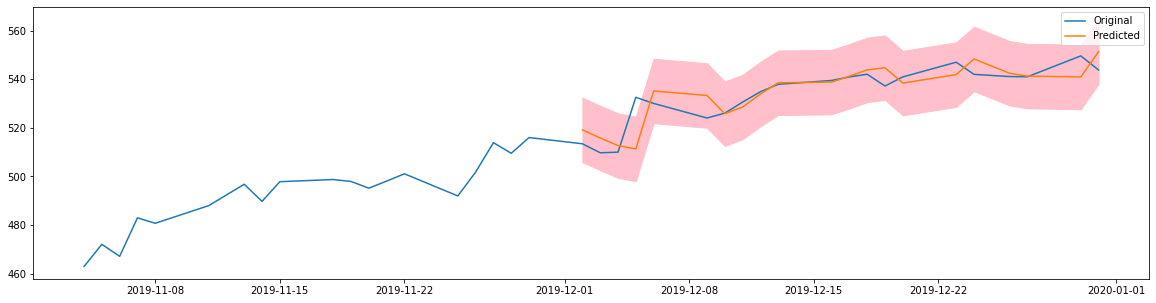

In [205]:
model=SARIMAX(df, order=(5,2,0)) #order(p,d,q) p=5,d=2,q=0 i.e ARIMA(5,2,0)
results = model.fit()

#2019-12-02 to 2019-12-31
forecast = results.get_prediction(start=-21)
y_pred=forecast.predicted_mean

# Get confidence intervals of forecasts
confidence_intervals = forecast.conf_int()

fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(df[df.index>'2019-11'])
ax.plot(y_pred)
# Shade uncertainty area
plt.fill_between(confidence_intervals.index, confidence_intervals['lower Open'], confidence_intervals['upper Open'], color='pink')

ax.legend(['Original','Predicted'])
plt.show()

In [206]:
y_true=df.iloc[-21:].values

print("MSE = ",mean_squared_error(y_true, y_pred))
print("RMSE = ",np.sqrt(mean_squared_error(y_true, y_pred)))
rmse['ARIMA_5_2']=np.sqrt(mean_squared_error(y_true, y_pred))

MSE =  43.415231695872706
RMSE =  6.5890235768187


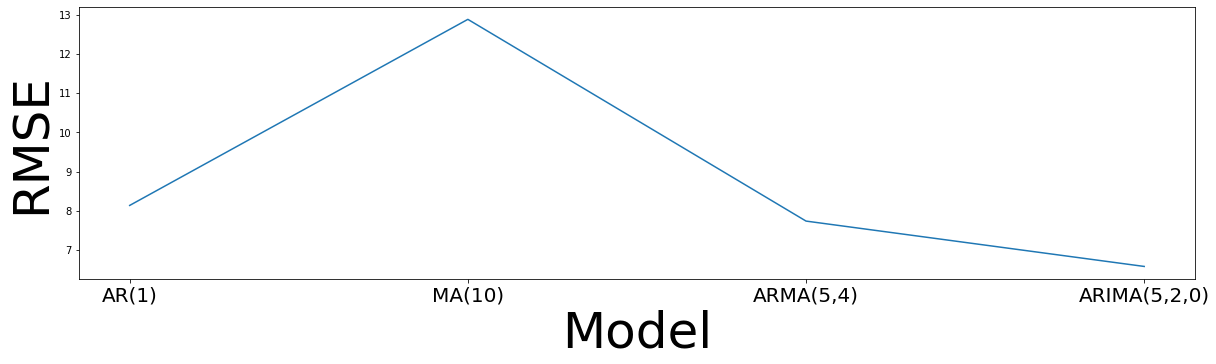

In [227]:
fig, ax = plt.subplots(figsize=(20, 5))


ax.plot(list(rmse.values()))
plt.xticks(list(range(len(rmse.values()))),['AR(1)','MA(10)','ARMA(5,4)','ARIMA(5,2,0)'],fontsize=20)
plt.xlabel('Model',fontsize=50)
plt.ylabel('RMSE',fontsize=50)
plt.show()

* # Hence ARIMA(5,2,0) [i.e AR order 5 , differencing order d=2 and MA order 0] perform better concluded from the above plot